# Decision Support System in Smart Supply Chains for Predicting Late Deliveries

The implementation of a Python-based Bayesian Network using pgmpy and applied to the “DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS” dataset. The primary goal of the DSS is to predict orders that would be delivered late. To achieve this, data-derived conditional probability distributions (CPDs) were used rather than assuming or estimating a priori knowledge of the CPDs. The performance of the DSS is compared to a multi-class classification machine learning model. The DSS can generate multiple insights and conduct what-if analyses to support decision-making.

_Keywords:_  Decision Support System (DSS), Bayesian Network, Supply Chain Management (SCM), decision-making


In [1]:
import pandas as pd
from io import StringIO

from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


## 1. Data Preparation & Cleaning

### 1.1 Load Source Date

In [2]:
df_source = pd.read_csv('data/raw/DataCoSupplyChainDataset.csv', encoding='unicode_escape')
df_source.drop_duplicates(inplace=True)

### 1.2 Data Description

In [3]:
df_description = pd.read_csv('data/raw/DescriptionDataCoSupplyChain.csv')
df_description.DESCRIPTION = df_description.DESCRIPTION.str.replace(':', '')

df_description.style.set_properties(**{'text-align': 'left'})

,FIELDS,DESCRIPTION
0,Type,Type of transaction made
1,Days for shipping (real),Actual shipping days of the purchased product
2,Days for shipment (scheduled),Days of scheduled delivery of the purchased product
3,Benefit per order,Earnings per order placed
4,Sales per customer,Total sales per customer made per customer
5,Delivery Status,"Delivery status of orders Advance shipping , Late delivery , Shipping canceled , Shipping on time"
6,Late_delivery_risk,"Categorical variable that indicates if sending is late (1), it is not late (0)."
7,Category Id,Product category code
8,Category Name,Description of the product category
9,Customer City,City where the customer made the purchase


## 2. Feature Engineering

Select the columns that will be used as the network nodes and remove duplicate records to have a single record per order.

In [4]:
nodes = [
    'Order Id',
    'Shipping Mode',
    'Customer Segment',
    'Days for shipment (scheduled)',
    'Delivery Status',
    'Customer State',
    'Market',
]

df_data = df_source[nodes] \
    .rename(columns={
        'Type': 'Payment Type',
        'Customer State': 'Store State'}) \
    .drop_duplicates() \
    .reset_index(drop=True)


print(df_data.shape)
with pd.option_context('display.max_columns', None):
    display(df_data.head())

(65752, 7)


,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
0,77202,Standard Class,Consumer,4,Advance shipping,PR,Pacific Asia
1,75939,Standard Class,Consumer,4,Late delivery,PR,Pacific Asia
2,75938,Standard Class,Consumer,4,Shipping on time,CA,Pacific Asia
3,75937,Standard Class,Home Office,4,Advance shipping,CA,Pacific Asia
4,75936,Standard Class,Corporate,4,Advance shipping,PR,Pacific Asia


In [5]:
# find columns with missing values
df_data.isnull().sum()

Order Id                         0
Shipping Mode                    0
Customer Segment                 0
Days for shipment (scheduled)    0
Delivery Status                  0
Store State                      0
Market                           0
dtype: int64

## 3. Create a Training and Test Set

In [6]:
# the random state is used to generate the same results for each run
random_state = 98421

In [7]:
# create the training dataset
df_test = df_data.sample(frac=0.3, random_state=random_state)
df_train = df_data.drop(df_test.index)

# reset the index of both datasets
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f'Training dataset shape : {df_train.shape}')
print(f'Test dataset shape     : {df_test.shape}')

Training dataset shape : (46026, 7)
Test dataset shape     : (19726, 7)


## 4. Model Training

### 4.1 Model Definition

Define the model nodes and edges.

In [8]:
# Create the Bayesian network model
model = BayesianNetwork()

# Add the nodes to the model
model.add_node('Shipping Mode')
model.add_node('Customer Segment')
model.add_node('Days for shipment (scheduled)')
model.add_node('Delivery Status')
model.add_node('Store State')
model.add_node('Market')

# Add the edges between the nodes to the model
model.add_edge('Delivery Status', 'Shipping Mode')
model.add_edge('Delivery Status', 'Customer Segment')
model.add_edge('Delivery Status', 'Days for shipment (scheduled)')
model.add_edge('Delivery Status', 'Store State')
model.add_edge('Delivery Status', 'Market')

### 4.2 Compute the Probability Distribution Table (PDT)

In [9]:
# show a simple parameter estimation of the shipping mode feature
pe = ParameterEstimator(model, df_train)
pe.state_counts('Shipping Mode')

Delivery Status,Advance shipping,Late delivery,Shipping canceled,Shipping on time
Shipping Mode,,,,
First Class,0.0,6719.0,313.0,0.0
Same Day,0.0,1110.0,119.0,1220.0
Second Class,0.0,6899.0,369.0,1725.0
Standard Class,10566.0,10479.0,1223.0,5284.0


In [10]:
# estimate the CPDs using the Bayesian estimator
model.fit(
    data=df_train, 
    estimator=BayesianEstimator,
    prior_type='BDeu',
    equivalent_sample_size=10)

In [11]:
# Check if the model is valid
model.check_model()

True

In [12]:
# show the CPDs of the model
model_cpds = model.get_cpds()
model_cpds

[<TabularCPD representing P(Shipping Mode:4 | Delivery Status:4) at 0x7f91a2adea30>,
 <TabularCPD representing P(Customer Segment:3 | Delivery Status:4) at 0x7f91a2ade520>,
 <TabularCPD representing P(Days for shipment (scheduled):4 | Delivery Status:4) at 0x7f91a2ade2b0>,
 <TabularCPD representing P(Delivery Status:4) at 0x7f91a2adecd0>,
 <TabularCPD representing P(Store State:46 | Delivery Status:4) at 0x7f91a2ade280>,
 <TabularCPD representing P(Market:5 | Delivery Status:4) at 0x7f91a2eab700>]

In [13]:
# show the computed CPD values
for cpd in model_cpds:
    print(f'--- {cpd.variable} ---')
    print(cpd.values, end='\n\n')

--- Shipping Mode ---
[[5.91380044e-05 2.66551300e-01 1.54761905e-01 7.59278382e-05]
 [5.91380044e-05 4.40558123e-02 5.90303479e-02 1.48287068e-01]
 [5.91380044e-05 2.73691466e-01 1.82395756e-01 2.09636761e-01]
 [9.99822586e-01 4.15701422e-01 6.03811991e-01 6.42000243e-01]]

--- Customer Segment ---
[[0.5214395  0.52055111 0.5254544  0.52017656]
 [0.3031493  0.29928532 0.28957974 0.29956063]
 [0.17541121 0.18016356 0.18496587 0.18026281]]

--- Days for shipment (scheduled) ---
[[5.91380044e-05 4.40558123e-02 5.90303479e-02 1.48287068e-01]
 [5.91380044e-05 2.66551300e-01 1.54761905e-01 7.59278382e-05]
 [5.91380044e-05 2.73691466e-01 1.82395756e-01 2.09636761e-01]
 [9.99822586e-01 4.15701422e-01 6.03811991e-01 6.42000243e-01]]

--- Delivery Status ---
[0.22957034 0.54760405 0.0440199  0.17880572]

--- Store State ---
[[5.14243517e-06 2.15584705e-06 2.68185670e-05 1.28086962e-04]
 [5.14243517e-06 2.15584705e-06 2.68185670e-05 1.28086962e-04]
 [1.94384049e-04 2.00493775e-04 2.68185670e-05 

### 4.3 Model Details

In [14]:
model.active_trail_nodes('Delivery Status')

{'Delivery Status': {'Customer Segment',
  'Days for shipment (scheduled)',
  'Delivery Status',
  'Market',
  'Shipping Mode',
  'Store State'}}

In [15]:
model.get_independencies()

(Store State ⟂ Customer Segment, Days for shipment (scheduled), Market, Shipping Mode | Delivery Status)
(Store State ⟂ Customer Segment, Days for shipment (scheduled), Market | Delivery Status, Shipping Mode)
(Store State ⟂ Days for shipment (scheduled), Market, Shipping Mode | Delivery Status, Customer Segment)
(Store State ⟂ Days for shipment (scheduled), Customer Segment, Shipping Mode | Delivery Status, Market)
(Store State ⟂ Customer Segment, Market, Shipping Mode | Delivery Status, Days for shipment (scheduled))
(Store State ⟂ Days for shipment (scheduled), Market | Delivery Status, Customer Segment, Shipping Mode)
(Store State ⟂ Days for shipment (scheduled), Customer Segment | Delivery Status, Market, Shipping Mode)
(Store State ⟂ Customer Segment, Market | Delivery Status, Days for shipment (scheduled), Shipping Mode)
(Store State ⟂ Days for shipment (scheduled), Shipping Mode | Delivery Status, Market, Customer Segment)
(Store State ⟂ Market, Shipping Mode | Delivery Status,

## 5. Model Queries

This section shows how the model can be used to answer questions about the data, make predictions, and generate insights.

In [16]:
infer = VariableElimination(model)

In [17]:
def get_ratios(probabilities: DiscreteFactor, col_name: str='Ratio') -> pd.DataFrame:
    """
    Show probabilities for a given variable.

    Parameters
    ----------
    probabilities : DiscreteFactor
        Probabilities for the variable.

    Returns
    -------
    pd.DataFrame
        Probabilities for the variable.
    """
    # Get the probabilities for each value
    value_probabilities = probabilities.values
    variable_name = list(probabilities.state_names.keys())[0]
    state_names = probabilities.state_names[variable_name]

    # create a dataframe with the probabilities
    return pd.DataFrame(
        data=value_probabilities,
        index=state_names,
        columns=[col_name]) \
        .sort_values(by=col_name, ascending=False)

### 5.1 What is the probability of a late delivery?

The probability of a late delivery is 0.55. This means that 55% of the orders in the training data were delivered late, which is a rather high percentage and indicates that the company has a problem with late deliveries.

In [18]:
late_delivery = infer.query(
    variables=['Delivery Status'],
    joint=False)

print(late_delivery['Delivery Status'])

+------------------------------------+------------------------+
| Delivery Status                    |   phi(Delivery Status) |
+====================================+========================+
| Delivery Status(Advance shipping)  |                 0.2296 |
+------------------------------------+------------------------+
| Delivery Status(Late delivery)     |                 0.5476 |
+------------------------------------+------------------------+
| Delivery Status(Shipping canceled) |                 0.0440 |
+------------------------------------+------------------------+
| Delivery Status(Shipping on time)  |                 0.1788 |
+------------------------------------+------------------------+


#### 5.1.1 What are the indicators that an order will ship on time?

In [19]:
# query the joint probabilities for shipping on time
on_time_factors = infer.query(
    variables=['Shipping Mode', 'Customer Segment', 'Store State'],
    evidence={'Delivery Status': 'Shipping on time'},
    joint=True)

# format the output
factor_string = on_time_factors._str(tablefmt='plain')
factor_stream = StringIO(factor_string)

pd.read_fwf(factor_stream, widths=[31, 31, 22, 54]) \
    .rename(columns={'phi(Shipping Mode,Customer Segment,Store State)': 'phi'}) \
    .replace('^.+\(', '', regex=True) \
    .replace('\)$', '', regex=True) \
    .sort_values(by='phi', ascending=False) \
    .reset_index(drop=True) \
    .head(20)


,Shipping Mode,Customer Segment,Store State,phi
0,Standard Class,Consumer,PR,0.1257
1,Standard Class,Corporate,PR,0.0724
2,Standard Class,Consumer,CA,0.0540
3,Standard Class,Home Office,PR,0.0436
4,Second Class,Consumer,PR,0.0410
5,Standard Class,Corporate,CA,0.0311
6,Same Day,Consumer,PR,0.0290
7,Second Class,Corporate,PR,0.0236
8,Standard Class,Consumer,NY,0.0213
9,Standard Class,Home Office,CA,0.0187


### 5.2 Which states handle the most late deliveries?

We can see that this is close the the same ratio as the total number of orders per state, the slight variance in numbers is because a `BayesianEstimator` was used to estimate the CPDs. If we had used a `MaximumLikelihoodEstimator` the numbers would be the same.

In [20]:
# Query the ratio of a late delivery for each state
state_late_delivery = infer.query(
    variables=['Store State'],
    evidence={'Delivery Status': 'Late delivery'})

get_ratios(state_late_delivery).head(5)

,Ratio
PR,0.384460
CA,0.163790
NY,0.061289
TX,0.051451
IL,0.042407


In [21]:
# verify the results with the source data
df_train['Store State'].value_counts(normalize=True).head(5)

PR    0.384457
CA    0.161908
NY    0.063138
TX    0.050841
IL    0.041259
Name: Store State, dtype: float64

#### 5.2.1 What is the probability of a late delivery per State?

This query shows the probability of late deliveries for all the stores in a state. This query differs from the previous as the number of orders are not considered, only the probability of a late delivery.

In [22]:
df_store_late_delivery = pd.DataFrame()

for state_name in list(state_late_delivery.state_names.values())[0]:
    # get the delivery status probabilities for the state using the bayesian network
    df_state = get_ratios(
        infer.query(
            variables=['Delivery Status'],
            evidence={'Store State': state_name})
    )

    # add the state name to the dataframe
    df_state['Store State'] = state_name

    # append the dataframe to the main dataframe    
    df_store_late_delivery = df_store_late_delivery.append(df_state \
        .reset_index(drop=False) \
        .rename(columns={'index': 'Delivery Status'})
    )

# show the stores with the highest probability of late delivery
df_store_late_delivery \
    .query('`Delivery Status` == "Late delivery"') \
    .drop(columns=['Delivery Status']) \
    .reindex(columns=['Store State', 'Ratio']) \
    .sort_values(by='Ratio', ascending=False) \
    .rename(columns={'Ratio': 'Probability of Late delivery'}) \
    .reset_index(drop=True) \
    .head(5)

,Store State,Probability of Late delivery
0,DE,0.636464
1,IA,0.605337
2,NM,0.602145
3,WA,0.593830
4,MN,0.580801


> We have discovered that the [state](https://www.scouting.org/resources/los/states/) Delaware (DE) has the highest probability of late delivery as reflected in the source data. This is an example that what require further investigation to improve the supply chain.

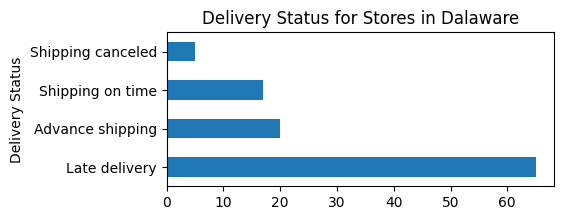

In [23]:
df_data[df_data['Store State'] == 'DE'].value_counts('Delivery Status').plot.barh(figsize=(5, 2), title='Delivery Status for Stores in Dalaware')
plt.show()

### 5.3 Which Market has the most late deliveries?

The European, Pacific Asia, and South American markets have the highest numbers of late deliver. This should be compared with the market profit to select the market to target first for improvement.

In [24]:
market_late_delivery = infer.query(
    variables=['Market'],
    evidence={'Delivery Status': 'Late delivery'})

get_ratios(market_late_delivery).head(5)


,Ratio
Europe,0.285150
Pacific Asia,0.268926
LATAM,0.257899
USCA,0.130090
Africa,0.057935


#### 5.3.1 What is the probability of a late delivery in Europe?

The probability of a late delivery in Europe is slightly higher than the global probability.

In [25]:
get_ratios(
    infer.query(
        variables=['Delivery Status'],
        evidence={'Market': 'Europe'}),
    col_name='Probability')

,Probability
Late delivery,0.553643
Advance shipping,0.230553
Shipping on time,0.173791
Shipping canceled,0.042013


#### 5.3.2 Which shipping method has the most late deliveries in the Pacific Asia Market?

Most of the late deliveries in the Pacific Asia market are due to the use of standard shipping.

In [26]:
shipping_mode_late_delivery = infer.query(
    variables=['Shipping Mode'],
    evidence={
        'Delivery Status': 'Late delivery',
        'Market': 'Pacific Asia'
    })

get_ratios(shipping_mode_late_delivery).head(5)

,Ratio
Standard Class,0.415701
Second Class,0.273691
First Class,0.266551
Same Day,0.044056


#### 5.3.3 What is the probability of a late delivery for orders in the Pacific Asia Market sipped using Standard Class?

When using standard shipping there is a 38% chance of a late delivery.

In [27]:
get_ratios(
    infer.query(
        variables=['Delivery Status'],
        evidence={
            'Shipping Mode': 'Standard Class',
            'Market': 'Pacific Asia'
        }),
    col_name='Probability'
).loc['Late delivery']

Probability    0.380781
Name: Late delivery, dtype: float64

#### 5.3.4 What is the probability of a late delivery for orders in the Pacific Asia Market sipped using Same Day Shipping?

Same Day shipping is often the most expensive shipping method, so customers would find it quite disappointing that there is a 46% chance of a late delivery using this shipping method.

In [28]:
get_ratios(
    infer.query(
        variables=['Delivery Status'],
        evidence={
            'Shipping Mode': 'Same Day',
            'Market': 'Pacific Asia'
        }),
    col_name='Probability'
).loc['Late delivery']

Probability    0.454464
Name: Late delivery, dtype: float64

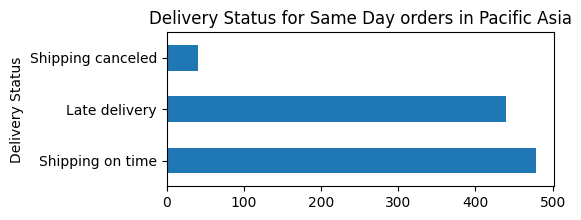

In [29]:
# show the delivery status for Same Day orders in Pacific Asia from the source data
df_data \
    .query('`Shipping Mode` == "Same Day" and `Market` == "Pacific Asia"') \
    .value_counts('Delivery Status') \
    .plot.barh(figsize=(5, 2), title='Delivery Status for Same Day orders in Pacific Asia')

plt.show()

## 1.7 Model Evaluation

In [30]:
# remove the label to predict
df_eval = df_test \
    .drop_duplicates() \
    .reset_index(drop=True)

df_eval.head()

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market
0,30009,Second Class,Corporate,2,Late delivery,FL,Pacific Asia
1,71466,First Class,Consumer,1,Late delivery,IL,Europe
2,54193,Standard Class,Consumer,4,Shipping on time,MI,LATAM
3,39822,Standard Class,Consumer,4,Advance shipping,FL,USCA
4,23171,Standard Class,Consumer,4,Advance shipping,OR,Pacific Asia


In [31]:
# predict the label
df_predict = model.predict(df_eval.drop(columns=['Order Id', 'Delivery Status']))
df_predict.rename(columns={
    'Delivery Status': 'y_pred'}, inplace=True)

# join the prediction back to the evaluation data
df_eval = df_eval.join(df_predict)

df_eval.head()

  0%|          | 0/1622 [00:00<?, ?it/s]

,Order Id,Shipping Mode,Customer Segment,Days for shipment (scheduled),Delivery Status,Store State,Market,y_pred
0,30009,Second Class,Corporate,2,Late delivery,FL,Pacific Asia,Late delivery
1,71466,First Class,Consumer,1,Late delivery,IL,Europe,Late delivery
2,54193,Standard Class,Consumer,4,Shipping on time,MI,LATAM,Advance shipping
3,39822,Standard Class,Consumer,4,Advance shipping,FL,USCA,Advance shipping
4,23171,Standard Class,Consumer,4,Advance shipping,OR,Pacific Asia,Advance shipping


In [32]:
# show the confusion matrix
confusion_matrix(
    y_true=df_eval['Delivery Status'],
    y_pred=df_eval['y_pred'])

array([[4561,    0,    0,    0],
       [4516, 5787,    0,  538],
       [ 469,  317,    0,   45],
       [2226,  728,    0,  539]])

In [33]:
# show the classification report
print(classification_report(
    y_true=df_eval['Delivery Status'],
    y_pred=df_eval['y_pred']))

/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

 Advance shipping       0.39      1.00      0.56      4561
    Late delivery       0.85      0.53      0.65     10841
Shipping canceled       0.00      0.00      0.00       831
 Shipping on time       0.48      0.15      0.23      3493

         accuracy                           0.55     19726
        macro avg       0.43      0.42      0.36     19726
     weighted avg       0.64      0.55      0.53     19726



/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vscode/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 1.7.1 Create a AutoML Model for Comparison

In [34]:
from pycaret.classification import *

In [35]:
classifier = setup(
    data=df_train.drop(columns=['Order Id']),
    target='Delivery Status',
    train_size=0.7,
    session_id=random_state,
    verbose=False)

In [36]:
# perform a model comparison
models = compare_models(n_select=3)
top_model = models[0]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.5519,0.7056,0.5519,0.6365,0.5294,0.3209,0.3748,0.1070
ridge,Ridge Classifier,0.5516,0.0000,0.5516,0.5526,0.5246,0.2563,0.2687,0.0940
lr,Logistic Regression,0.5509,0.7106,0.5509,0.5441,0.5220,0.2438,0.2539,0.5690
dummy,Dummy Classifier,0.5477,0.5000,0.5477,0.2999,0.3876,0.0000,0.0000,0.1060
ada,Ada Boost Classifier,0.5443,0.6670,0.5443,0.4133,0.4438,0.0738,0.0979,0.1950
svm,SVM - Linear Kernel,0.5440,0.0000,0.5440,0.4622,0.4675,0.1360,0.1640,0.1330
knn,K Neighbors Classifier,0.5397,0.5319,0.5397,0.4547,0.4309,0.0516,0.0762,0.2400
rf,Random Forest Classifier,0.5303,0.5260,0.5303,0.4414,0.4237,0.0444,0.0608,0.2770
et,Extra Trees Classifier,0.5289,0.5532,0.5289,0.4414,0.4224,0.0430,0.0587,0.2720
gbc,Gradient Boosting Classifier,0.5275,0.6402,0.5275,0.4372,0.4209,0.0425,0.0580,0.8980


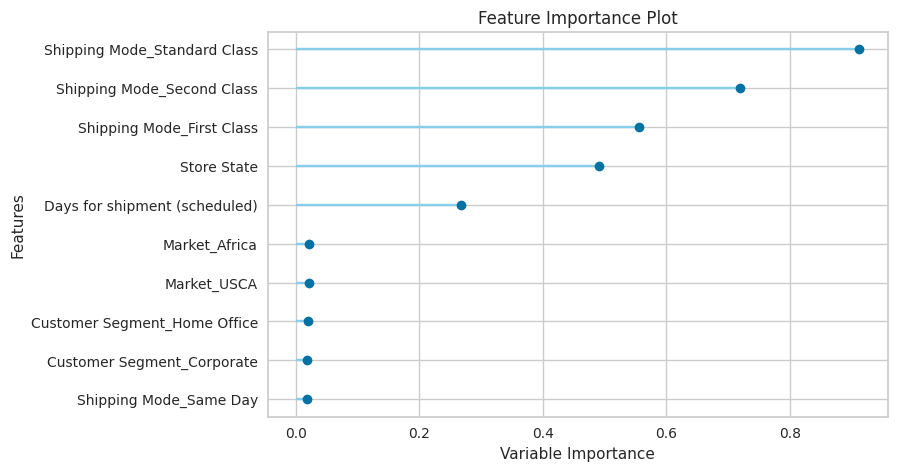

In [37]:
# plot the feature importance
plot_model(top_model, plot='feature')

In [38]:
# perform predictions on the test data
df_predicted = predict_model(estimator=top_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.5514,0.6990,0,0,0,0.3185,0.3698


In [39]:
# show the confusion matrix
confusion_matrix(
    y_true=df_predicted['Delivery Status'],
    y_pred=df_predicted['prediction_label'])

array([[4467,   94,    0,    0],
       [4432, 5871,    0,  538],
       [ 469,  317,    0,   45],
       [2196,  758,    0,  539]])

In [40]:
# show the classification report
print(classification_report(
    y_true=df_predicted['Delivery Status'],
    y_pred=df_predicted['prediction_label']))

                   precision    recall  f1-score   support

 Advance shipping       0.39      0.98      0.55      4561
    Late delivery       0.83      0.54      0.66     10841
Shipping canceled       0.00      0.00      0.00       831
 Shipping on time       0.48      0.15      0.23      3493

         accuracy                           0.55     19726
        macro avg       0.43      0.42      0.36     19726
     weighted avg       0.63      0.55      0.53     19726

